# OpenPIV Tutorial


In this tutorial we read the pair of images using `imread`, compare them visually 
and process using OpenPIV. Here the import is using directly the basic functions and methods

In [26]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio

In [27]:
frame_a  = tools.imread( '../../examples/test1/exp1_001_a.bmp' )
frame_b  = tools.imread( '../../examples/test1/exp1_001_b.bmp' )

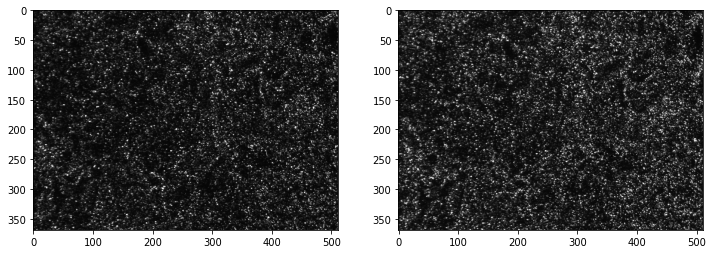

In [28]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [29]:
winsize = 24 # pixels
searchsize = 64  # pixels, search in image B
overlap = 12 # pixels
dt = 0.02 # sec


u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

In [30]:
x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)

In [31]:
u1, v1, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.3 )

In [32]:
u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)

In [33]:
x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 96.52 )

In [34]:
tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )

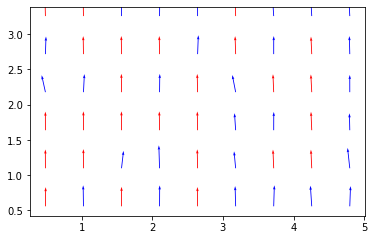

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [35]:
tools.display_vector_field('exp1_001.txt', scale=50, width=0.0025)

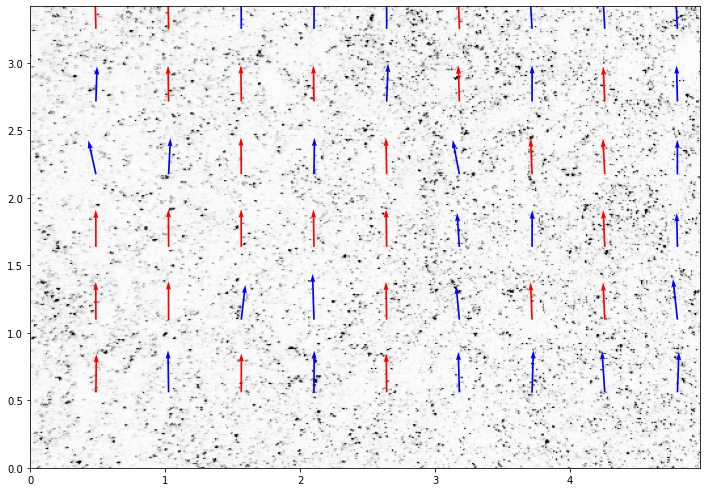

In [36]:
# If you need a larger view:

fig, ax = plt.subplots(figsize=(12,12))
tools.display_vector_field(
    'exp1_001.txt',
    ax=ax,
    scaling_factor=96.52,
    scale=50,
    width=0.0025,
    on_img=True,
    image_name='../../examples/test1/exp1_001_a.bmp');